# McKinney Chapter 11 - Practice (Monday 2:45 PM, Section 3)

## Announcements

- Quiz 4 - mean was $87\%$
- Project 1 and Teammates Reviews on Friday at 11:59 PM

##  Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import requests_cache
session = requests_cache.CachedSession()
import yfinance as yf
import pandas_datareader as pdr

### Which are larger, overnight or intraday returns?

Yahoo! Finance provides easy acces to high-quality open, high, low, close (OHLC) and adjusted close price data.
However, Yahoo! Finance does not provide overnight or instraday returns directly.
Therefore, we need to use math to decompose daily returns into overnight and intraday returns.

Daily returns are defined as (adjusted) closing price to (adjusted) closing price returns.
Therefore, daily returns consist of overnight returns compounded with the intraday returns from the next day $(1 + R_{daily}) = (1 + R_{overnight}) \times (1 + R_{intraday})$ which we can rearrange to calculate overnight returns as $\frac{1 + R_{daily}}{1 + R_{intraday}} - 1 = R_{overnight}$.

We can calculate daily and intraday returns from Yahoo! Finance data as $R_{daily} = \frac{Adj\ Close_{t} - Adj\ Close_{t-1}}{Adj\ Close_{t-1}}$ and $R_{intraday} = \frac{Close - Open}{Open}$.

Compare the following for the SPY ETF:

1. Cumulative returns with all available data
1. Total returns for each calendar year
1. Total returns over rolling 252-trading-day windows
1. Total returns over rolling 12-months windows after calculating monthly returns
1. Sharpe Ratios for each calendar year

#### Intraday and overnight return decomposition

In [4]:
spy = yf.download(tickers='SPY', progress=False)

In [5]:
returns = (
    spy
    .assign(
        Date = lambda x: x.index.tz_localize(None), # remove time zone from date index
        Total = lambda x: x['Adj Close'].pct_change(), # close-to-close
        Intraday = lambda x: (x['Close'] / x['Open']) - 1, # open-to-close
        Overnight = lambda x: ((1 + x['Total']) / (1 + x['Intraday'])) - 1 # remainder is close-to-open
    )
    .set_index('Date') # replace index with time-zome-less index
    .dropna() # drop first day with incomplete returns
    [['Total', 'Intraday', 'Overnight']] # slice returns columns
    .rename_axis(columns='Return') # name columns axis
)

### Cumulative returns with all available data

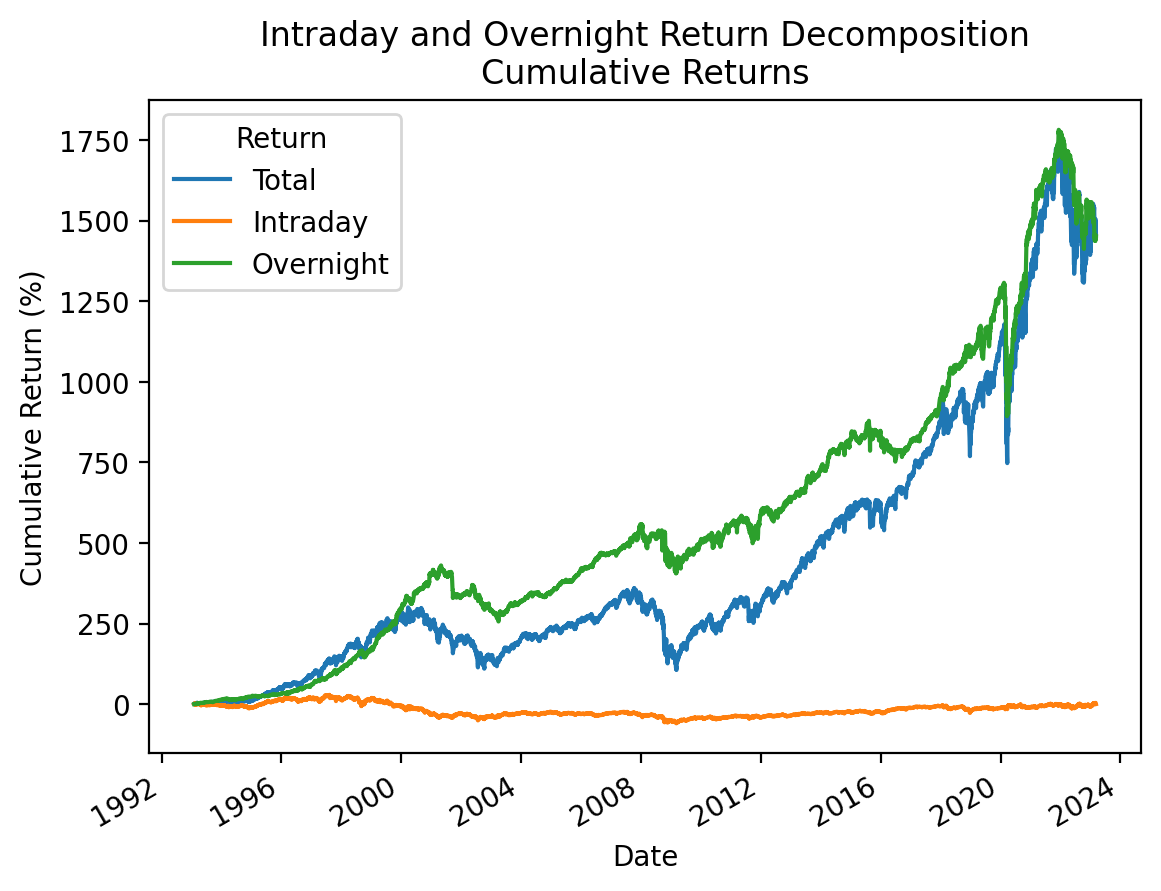

In [6]:
returns.add(1).cumprod().sub(1).mul(100).plot()
plt.ylabel('Cumulative Return (%)')
plt.title('Intraday and Overnight Return Decomposition\nCumulative Returns')
plt.show()

We want to calcuate total returns at several different aggregation levels.
A helper function makes this code more compact and easier to troubleshoot.

In [7]:
def totret(x):
    return (1 + x).prod() - 1

#### Total returns for each calendar year

First, total returns for each calendar year.
Note, the first and last years are partial (i.e., do not include about 252 trading days).

In [8]:
returns_a = returns.resample('A', kind='period').apply(totret)

returns_a.head()

Return,Total,Intraday,Overnight
Date,,,
1993,0.0871,-0.0443,0.1374
1994,0.0040,-0.0774,0.0881
1995,0.3805,0.2857,0.0738
1996,0.2250,0.0236,0.1968
1997,0.3348,-0.0017,0.3370


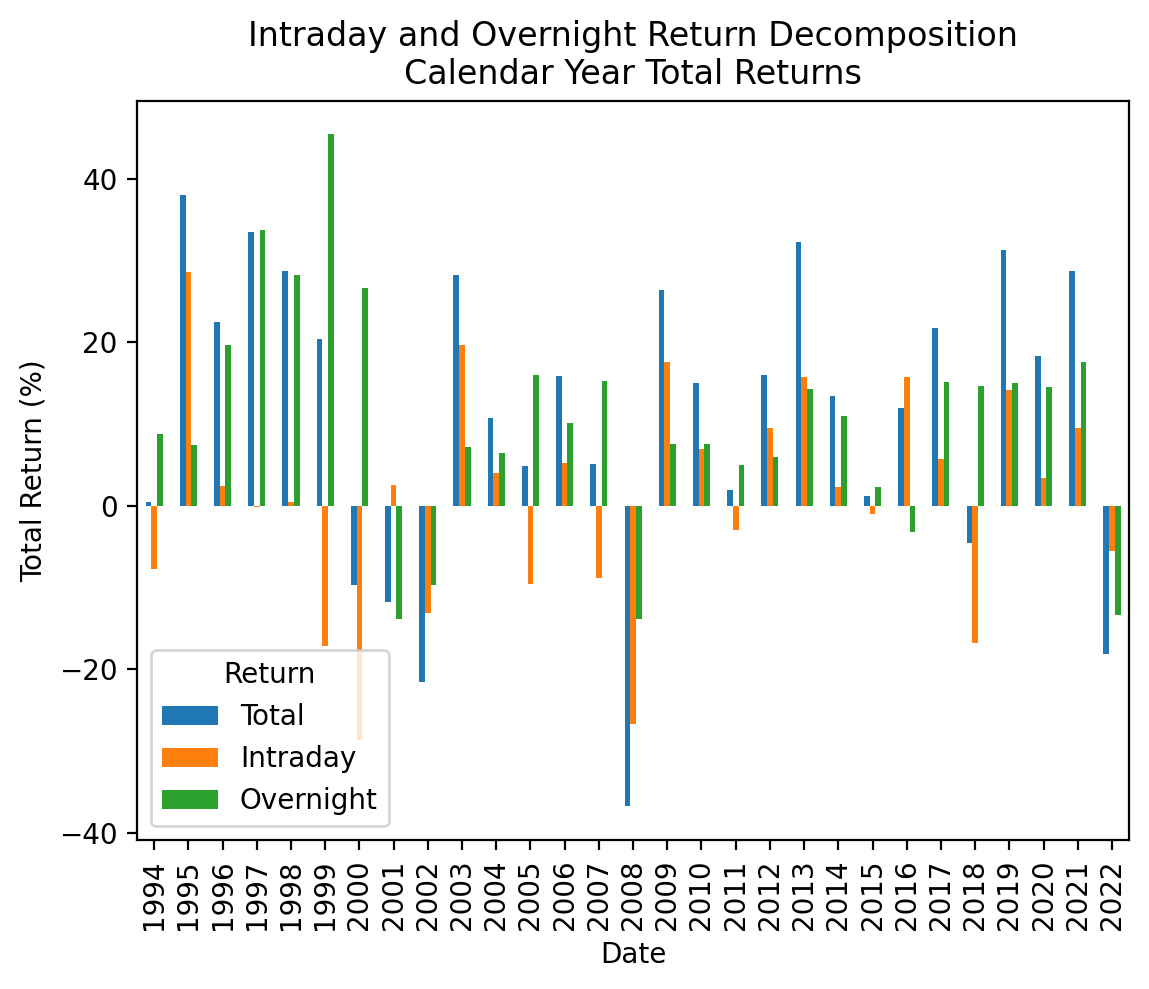

In [9]:
returns_a.iloc[1:-1].mul(100).plot(kind='bar')
plt.ylabel('Total Return (%)')
plt.title('Intraday and Overnight Return Decomposition\nCalendar Year Total Returns')
plt.show()

We can get the same result without defining a `totret()` function, but then we use a lambda function, which can be tedious.

In [10]:
returns_a_alt = returns.resample('A', kind='period').apply(lambda x: (1 + x).prod() - 1)

returns_a_alt.head()

Return,Total,Intraday,Overnight
Date,,,
1993,0.0871,-0.0443,0.1374
1994,0.0040,-0.0774,0.0881
1995,0.3805,0.2857,0.0738
1996,0.2250,0.0236,0.1968
1997,0.3348,-0.0017,0.3370


In [11]:
np.allclose(
    returns_a,
    returns_a_alt
)

True

If we only want the total return for `Intraday`, we can slice `returns` before we `.resample()`.

In [12]:
returns['Intraday'].resample('A', kind='period').apply(totret).head()

Date
1993   -0.0443
1994   -0.0774
1995    0.2857
1996    0.0236
1997   -0.0017
Freq: A-DEC, Name: Intraday, dtype: float64

#### Total returns over rolling 252-trading-day windows

We can repeat the total return calculation for 252-trading-day rolling windows.

In [13]:
returns_r = returns.rolling(252).apply(totret)

returns_r.head()

Return,Total,Intraday,Overnight
Date,,,
1993-02-01,NaN,NaN,NaN
1993-02-02,NaN,NaN,NaN
1993-02-03,NaN,NaN,NaN
1993-02-04,NaN,NaN,NaN
1993-02-05,NaN,NaN,NaN


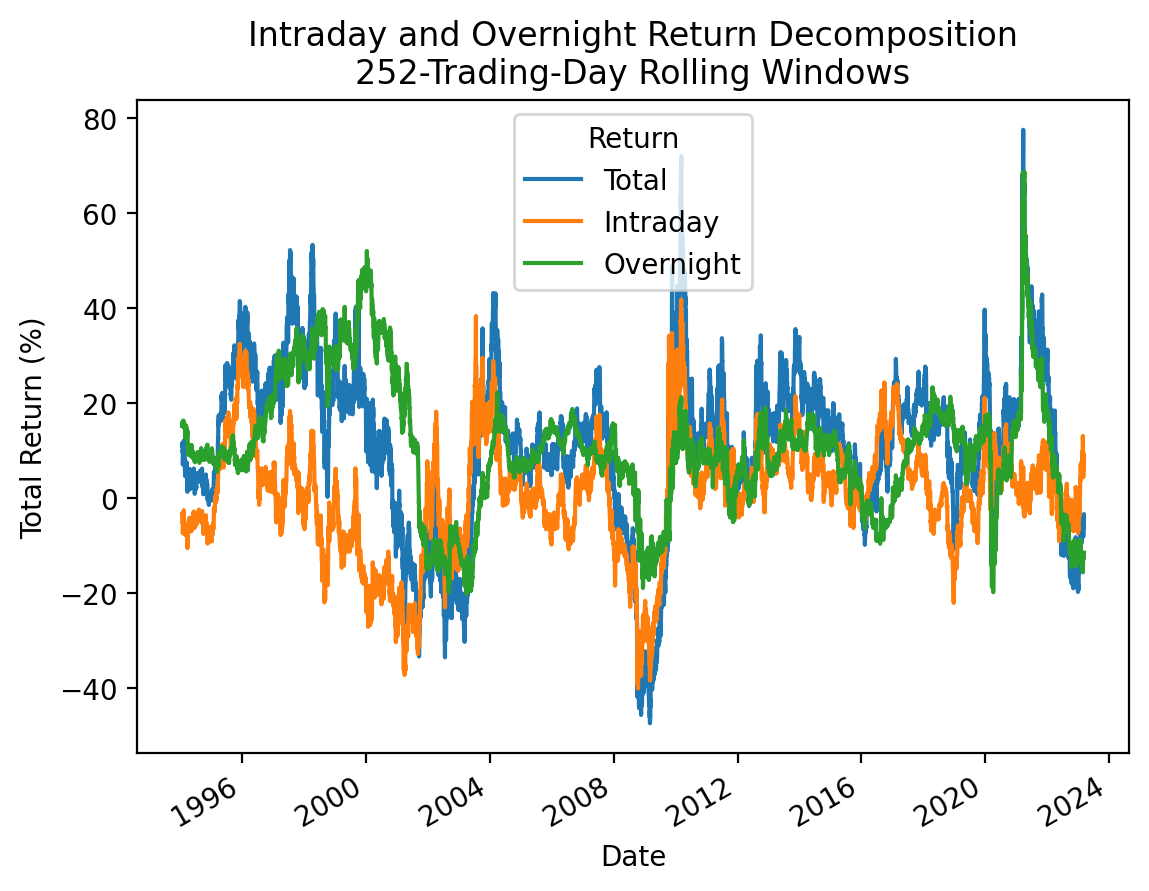

In [14]:
returns_r.mul(100).plot()
plt.ylabel('Total Return (%)')
plt.title('Intraday and Overnight Return Decomposition\n252-Trading-Day Rolling Windows')
plt.show()

#### Total returns over rolling 12-months windows after calculating monthly returns

We can chain this operation!
Note the plot has the same general appearance, but is less noisy because we aggregate to monthly total returns first!

In [15]:
returns_mr = (
    returns
    .resample(rule='M', kind='period') # aggregate from daily to monthly
    .apply(totret) # ...calculate total returns
    .rolling(12) # aggregate into 12-month rolling windows
    .apply(totret) # ...calculate total returns
)

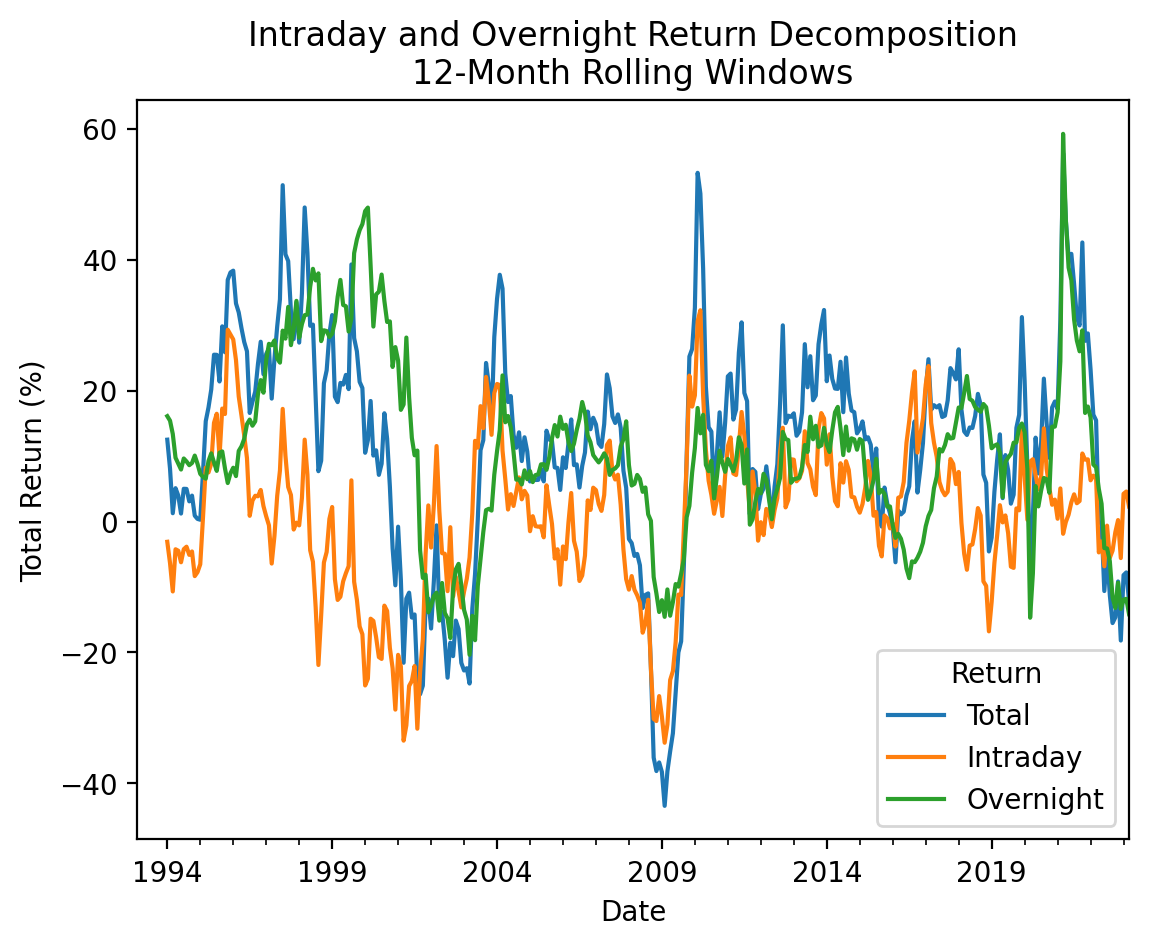

In [16]:
returns_mr.mul(100).plot()
plt.ylabel('Total Return (%)')
plt.title('Intraday and Overnight Return Decomposition\n12-Month Rolling Windows')
plt.show()

#### Sharpe Ratios for each calendar year

We need the risk-free rate `RF` from Ken French's daily benchmark factors.

In [17]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900',
        session=session
    )
    [0]
    .div(100)
)

I think this easiest (and fastest approach) is to:

1. Calculate a data frame of excess returns
1. Use an anonymous (lambda) function

In [18]:
returns_excess = (
    returns
    .sub(ff['RF'], axis=0) # note axis=0 for column-wise subtraction
    .dropna()
)

In [19]:
sharpes_a = (
    returns_excess
    .resample(rule='A', kind='period')
    .apply(lambda x: np.sqrt(252) * x.mean() / x.std())
)

sharpes_a.head()

Return,Total,Intraday,Overnight
Date,,,
1993,0.7233,-0.9172,2.8058
1994,-0.2732,-1.1871,0.8819
1995,3.1845,2.5275,0.4197
1996,1.2247,-0.1691,1.6658
1997,1.2796,-0.1781,2.5565


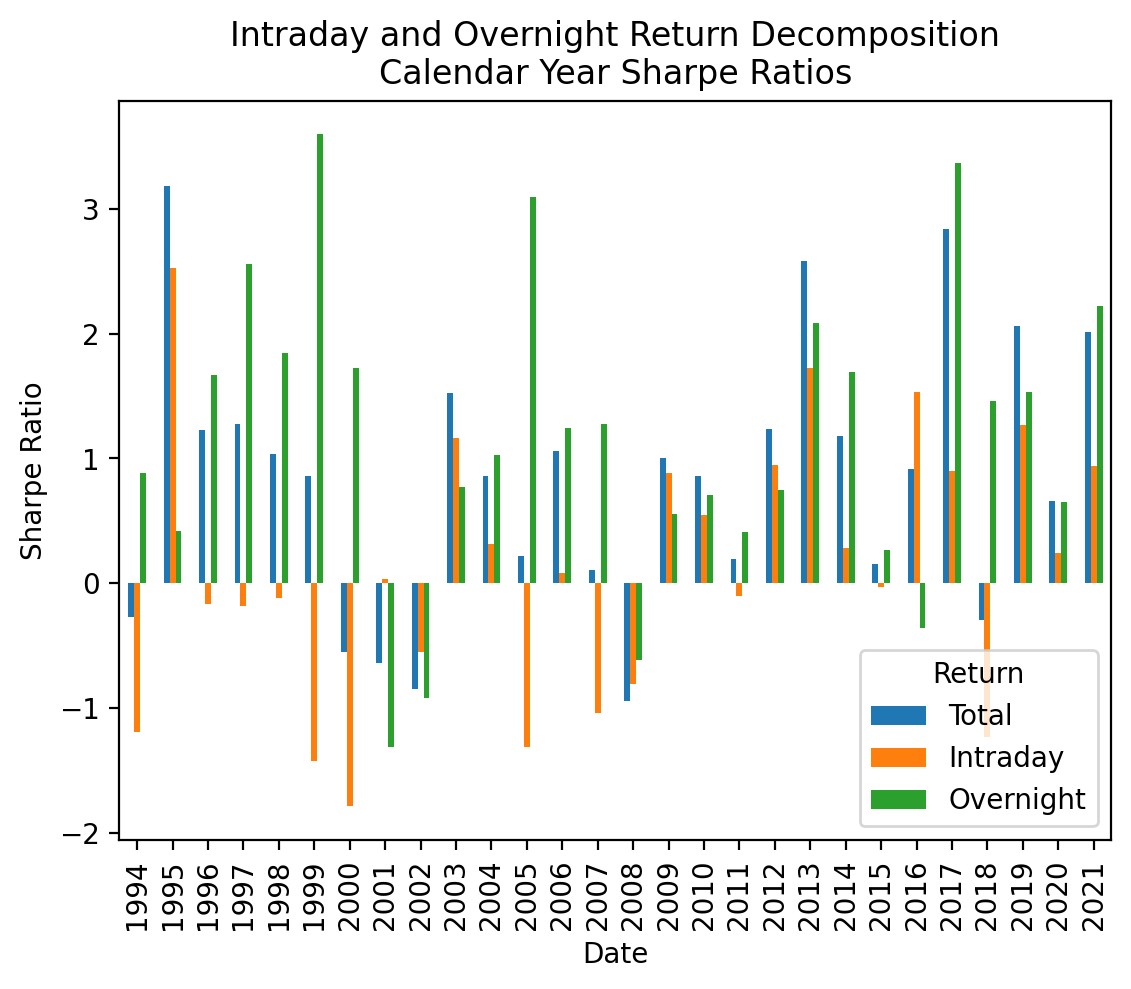

In [20]:
sharpes_a.iloc[1:-1].plot(kind='bar')
plt.ylabel('Sharpe Ratio')
plt.title('Intraday and Overnight Return Decomposition\nCalendar Year Sharpe Ratios')
plt.show()

### Calculate rolling betas

Calculate rolling capital asset pricing model (CAPM) betas for the MATANA stocks.

The CAPM says the risk premium on a stock depends on the risk-free rate, beta, and the risk premium on the market: $E(R_{stock}) = R_f + \beta_{stock} \times (E(R_{market}) - R_f)$.
We can calculate CAPM betas as: $\beta_{stock} = \frac{Cov(R_{stock} - R_f, R_{market} - R_f)}{Var(R_{market} - R_f)}$.

In [21]:
matana = (
    yf.download(tickers='MSFT AAPL TSLA AMZN NVDA GOOG', progress=False)
    .assign(
        Date = lambda x: x.index.tz_localize(None),
    )
    .set_index('Date')
    ['Adj Close']
    .pct_change()
    .rename_axis(columns='Ticker')
)

matana.head()

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
Date,,,,,,
1980-12-12,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,-0.0522,NaN,NaN,NaN,NaN,NaN
1980-12-16,-0.0734,NaN,NaN,NaN,NaN,NaN
1980-12-17,0.0248,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.0290,NaN,NaN,NaN,NaN,NaN


In [22]:
def beta(ri, rf=ff['RF'], rm_rf=ff['Mkt-RF']):
    ri_rf = ri.sub(rf).dropna()
    return ri_rf.cov(rm_rf) / rm_rf.loc[ri_rf.index].var()

A few notes:

1. Here the `beta()` function is too smart for the `.rolling()` method.
    Our `beta()` function matches stock and market data, but may not use 252 trading days at the end of the sample.
    For example, in February 2023, we can slice a 252-trading-day window from the `matana` data frame.
    However, the `beta()` function does not use January and Februrary 2023 data because they are missing from the `ff` data frame.
    The easiest fix is to slice the `matana` data frame to remove 2023 data before we apply the `.rolling()` method.
2. The `.apply()` method and `beta()` function are *very slow* because they slice inefficiently!
    We will write faster---but uglier---code below.

In [23]:
%%time
betas_1 = matana.dropna().loc[:'2022'].rolling(252).apply(beta)

CPU times: user 13.8 s, sys: 68 µs, total: 13.8 s
Wall time: 13.8 s


Here is the fast solution, which uses the optimized `.cov()` and `.var()` to calculate the numerator and denominator for $\beta$.

In [24]:
%%time
cov_2 = matana.dropna().loc[:'2022'].sub(ff['RF'], axis=0).rolling(252).cov(ff['Mkt-RF'])
var_2 = ff['Mkt-RF'].rolling(252).var()
betas_2 = cov_2.div(var_2, axis=0)

CPU times: user 8.41 ms, sys: 0 ns, total: 8.41 ms
Wall time: 8.32 ms


These solutions are identical!
Even though `beta_2` is 1000 times faster than `beta_1`, you should use the approach that makes the most sense to you!

In [25]:
np.allclose(betas_1.dropna(), betas_2.dropna())

True

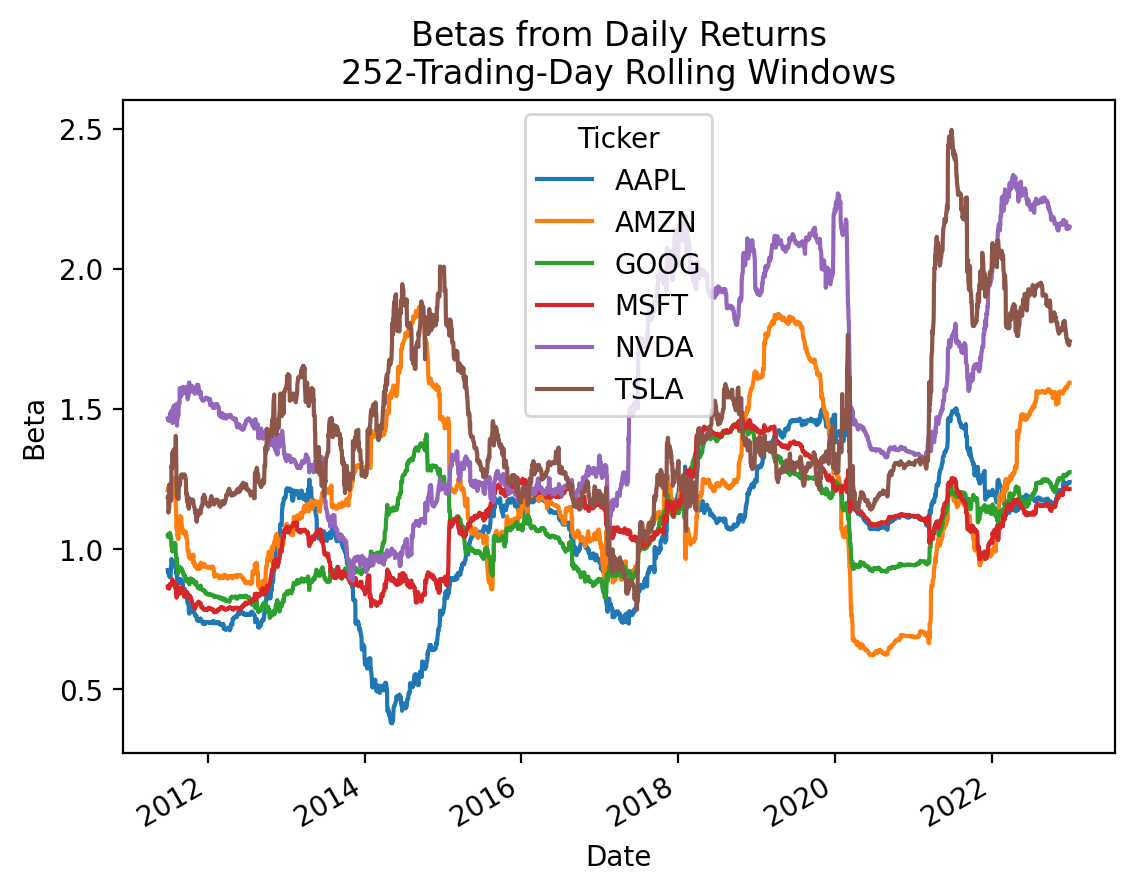

In [26]:
betas_1.plot()
plt.ylabel('Beta')
plt.title('Betas from Daily Returns\n252-Trading-Day Rolling Windows')
plt.show()

### Calculate rolling Sharpe Ratios

Calculate rolling Sharpe Ratios for the MATANA stocks.

The Sharpe Ratio is often used to evaluate fund managers.
The Sharpe Ratio is $SR_i = \frac{\overline{R_i - R_f}}{\sigma}$, where $\overline{R_i-R_f}$ is mean fund return relative to the risk-free rate over some period and $\sigma$ is the standard deviation of $R_i-R_f$ over the same period.
While the Sharpe Ratio is typically used for funds, we can apply it to a single stock to test our knowledge of the `.rolling()` method.
Calculate and plot the one-year rolling Sharpe Ratio for the MATANA stocks using all available daily data.

In [27]:
def sharpe(ri, rf=ff['RF'], ann_fac=np.sqrt(252)):
    ri_rf = ri.sub(rf).dropna()
    return ann_fac * ri_rf.mean() / ri_rf.std()

See the discussion in the beta exercise above about how we can end up with a result based on fewer than 252 trading days of data because the `sharpe()` function matches the `matana` and `ff` data frames *after* the `.rolling()` mehtod slices a 252 trading day window.
The simplest solution is the remove the 2023 data from the `matana` data frame before we apply the `.rolling()` method.

In [28]:
%%time
sharpes_1 = matana.dropna().loc[:'2022'].rolling(252).apply(sharpe)

CPU times: user 6.5 s, sys: 22 µs, total: 6.5 s
Wall time: 6.5 s


Here is the fast solution, which:

1. Uses the `.sub()` method to calculate excess returns
1. Then uses the optimized `.mean()` and `.std()` methods to calculate the numerator and denominator for the Sharpe Ratios

In [29]:
mean_2 = matana.dropna().loc[:'2022'].sub(ff['RF'], axis=0).rolling(252).mean()
std_2 = matana.dropna().loc[:'2022'].sub(ff['RF'], axis=0).rolling(252).std()
sharpes_2 = mean_2.div(std_2, axis=0).mul(np.sqrt(252))

In [30]:
np.allclose(sharpes_1.dropna(), sharpes_2.dropna())

True

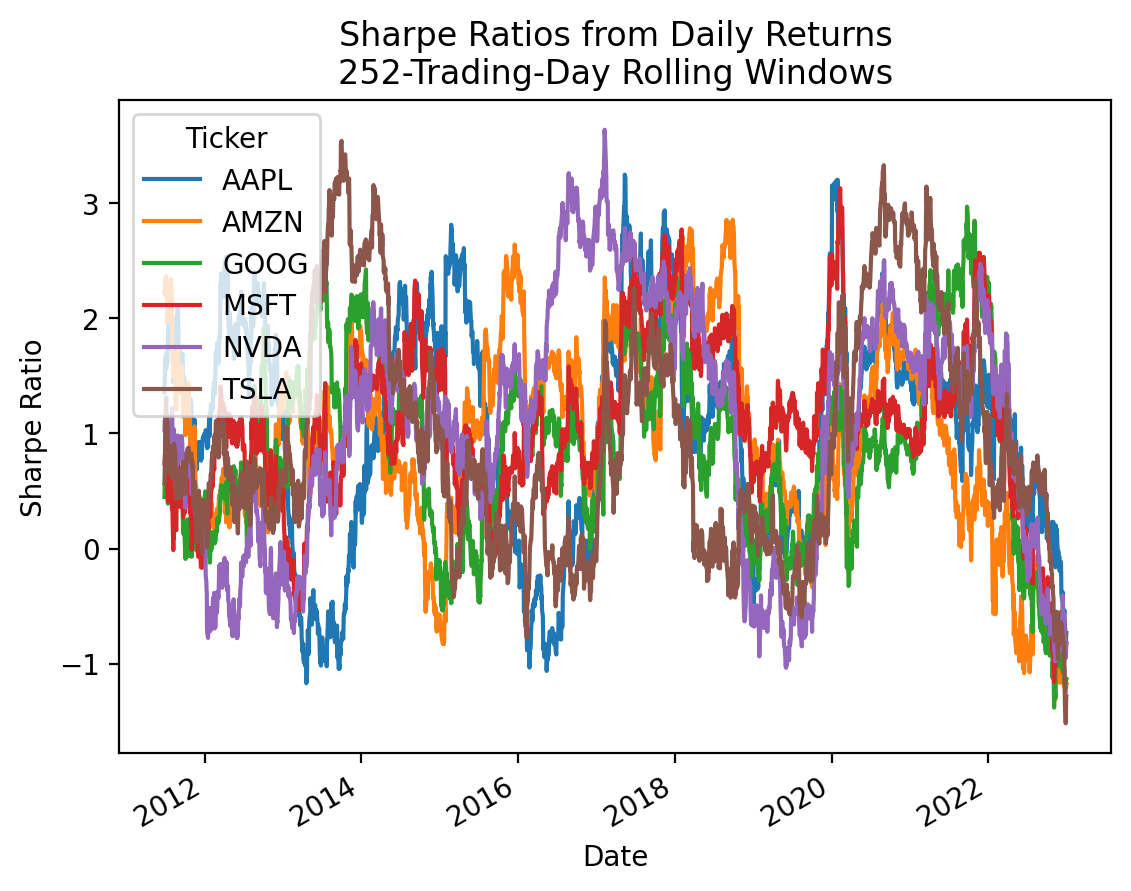

In [31]:
sharpes_1.plot()
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios from Daily Returns\n252-Trading-Day Rolling Windows')
plt.show()

### Does more frequent rebalancing increase or decrease returns?

Compare decade-total returns for the following rebalancing frequencies:

1. Daily rebalancing
1. Monthly rebalancing
1. Annual rebalancing
1. Decade rebalancing

Use equally-weighted portfolios of industry-level daily returns from French's website: `'17_Industry_Portfolios_daily'`.

***This exercise is a little early, and we will revisit later in the course!***